<a href="https://www.kaggle.com/rsizem2/tps-10-21-adversarial-validation?scriptVersionId=84759151" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Adversarial Validation

In this notebook, we use adversarial validation to test the similarity of the training and test data. I made a [post](https://www.kaggle.com/c/tabular-playground-series-oct-2021/discussion/276712) about this on the discussion boards and figured I should make a notebook for others to inspect.

The idea behind adversarial validation is that if there are differences in the training and test data distributions an algorithm like XGBoost should be able to find these differences and use them to distinguish the two sets. So we create a classification problem where we predict whether a sampling of the data comes from the training or test sets. Ideally, we hope to see ~.5 AUC which would mean that our algorithm couldn't find meaningful distinctions between the test and training data.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 3
SAMPLES = 100000

In [2]:
import numpy as np
import pandas as pd
import time
import os
import gc

# Hide warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Plotting
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

# Model and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
import shap

## Load Data

Helper function which samples the training and test sets in preparation for adversarial validation.

In [3]:
def get_data(n_samples = 100000):
    start = time.time()
    
    # Load and sample training data
    train = pd.read_csv('../input/tabular-playground-series-oct-2021/train.csv')
    train.drop(['id', 'target'], axis = 'columns', inplace = True)
    train = train.sample(n = n_samples, random_state = RANDOM_SEED)
    gc.collect()

    # Load and sample test data
    test = pd.read_csv('../input/tabular-playground-series-oct-2021/test.csv')
    test.drop('id', axis = 'columns', inplace = True)
    test = test.sample(n = n_samples, random_state = RANDOM_SEED)
    gc.collect()
    
    data = train.append(test).reset_index(drop = True)
    data['test'] = [0] * len(train) + [1] * len(test)
    data.reset_index(drop = True, inplace = True)
    
    for col, dtype in data.dtypes.iteritems():
        if dtype.name.startswith('int'):
            data[col] = pd.to_numeric(data[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            data[col] = pd.to_numeric(data[col], downcast ='float')
    
    train, valid = train_test_split(data, stratify = data['test'])
    
    end = time.time()
    print(f"Data retrieved in {round(end-start,2)}s.")
    return train, valid

# Adversarial Validation

We use [XGBoost](https://xgboost.readthedocs.io/en/latest/python/index.html)  and a random sampling of 100,000 rows from both the training and test data (200k total):

In [4]:
# Load data
train, valid = get_data(n_samples = SAMPLES)
features = [x for x in train.columns if x != 'test']

# Define and train model
start = time.time()
model = XGBClassifier(
    random_state = RANDOM_SEED,
    tree_method='gpu_hist',
    gpu_id=0,
    predictor="gpu_predictor",
)
model.fit(
    train[features], train['test'], 
    eval_metric = 'auc',
    verbose = False
)

# Get AUC from validation set
valid_auc = roc_auc_score(
    y_true = valid['test'], 
    y_score = model.predict_proba(valid[features])[:,1],
)
end = time.time()

print(f'Validation AUC: {round(valid_auc, 6)} in {round(end-start, 2)}s.')

Data retrieved in 90.46s.
Validation AUC: 0.967558 in 5.97s.


We see a validation AUC of `> .95` which seems to suggest significant differences in the training and test distributions.

# XGBoost Feature Importance

It may be useful to examine these features which XGBoost found useful for distinguishing the training and test data. We use consider the following importance types:

* `weight` is the number of times a feature appears in a tree
* `gain` is the average gain of splits which use the feature
* `cover` is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

Above descriptions taken from the XGBoost Plotting API [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting).

## 1. Importance Type: Weight

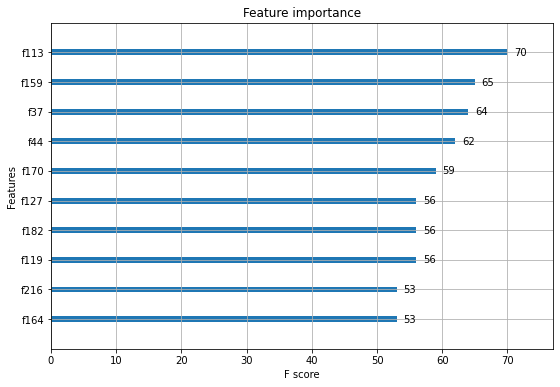

In [5]:
# Top 10 features by importance type "Weight"
fig, ax = plt.subplots(figsize = (9,6))
xgb.plot_importance(
    model,
    ax = ax,
    importance_type = "weight",
    max_num_features = 10,
)
plt.show()

## 2. Importance Type - Gain

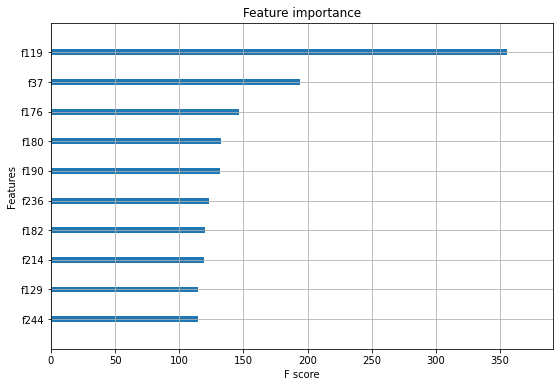

In [6]:
# Top 10 features by importance type "Gain"
fig, ax = plt.subplots(figsize = (9,6))
xgb.plot_importance(
    model,
    ax = ax,
    importance_type = "gain",
    max_num_features = 10,
    show_values = False, # looks bad
)
plt.show()

## 3. Importance Type - Cover

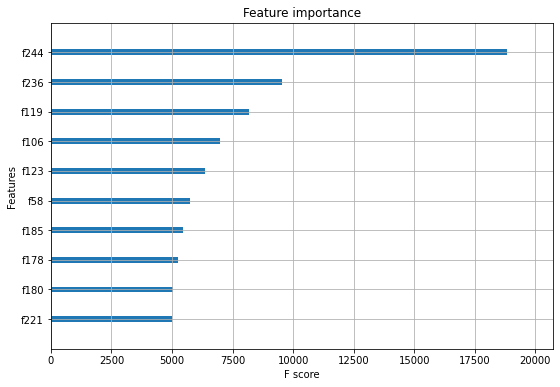

In [7]:
# Top 10 features by importance type "Cover"
fig, ax = plt.subplots(figsize = (9,6))
xgb.plot_importance(
    model,
    ax = ax,
    importance_type = "cover",
    max_num_features = 10,
    show_values = False, # looks bad
)
plt.show()

We see that different features are considered important based on which importance type we consider.

# XGBoost SHAP Values

Finally, we can use our fitted model to calculate feature importances using SHAP values:

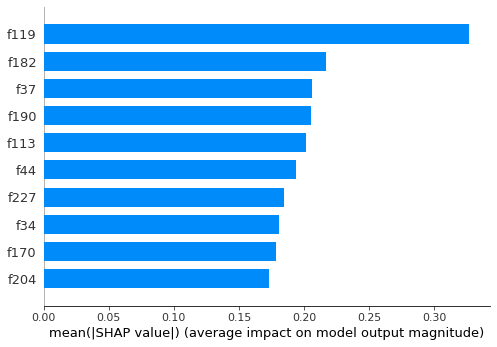

In [8]:
# Top 10 features by SHAP values
booster_xgb = model.get_booster()
shap_values_xgb = booster_xgb.predict(
    xgb.DMatrix(train[features], train['test']), 
    pred_contribs=True
)

shap.summary_plot(
    shap_values_xgb[:, :-1], train[features], 
    feature_names=features, 
    plot_type="bar",
    max_display = 10,
)

We see there are several features that are consistently considered important for distinguishing the test set from the training set. It may be worth examining these features.